In [9]:
import numpy as np
import matplotlib.pyplot as plt

from gpesim_1d import GPETimeEv as gpe

In [10]:
import matplotlib.animation as animation

## Initialize

In [11]:
g = gpe( L = 50)

KeyboardInterrupt: 

In [4]:
np.sum(g.psi**2)*g.dx

(5119.999999999998-4.4286279152940163e-13j)

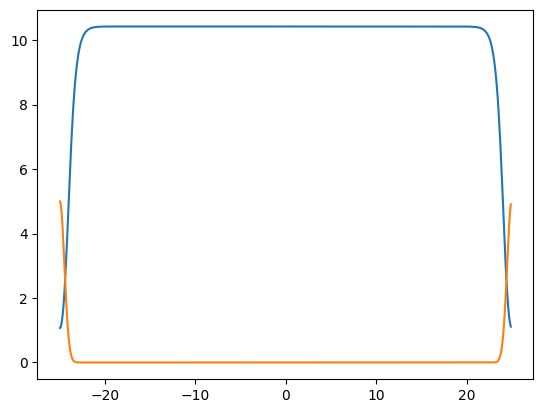

In [5]:
plt.figure() 
plt.plot(g.xi[0], np.real(g.psi))

plt.plot(g.xi[0], g.Vbox)

In [6]:
print(len(g.psi))

512


## Bogoliubov Coefficients

In [7]:
uv_arr = np.zeros((len(g.xi[0]),2))
print(uv_arr.shape)


(512, 2)


In [8]:
for i in range(len(g.ki[0])):
    if g.ki[0][i] == 0:
        uv_arr[i] = [0,0]
    else: 
        e_frac = np.sqrt(g.ki[0][i]**2/(g.ki[0][i]**2 + 4))
        uv_arr[i] = [0.5 * (e_frac**0.5 + e_frac**(-0.5)),0.5 * (e_frac**0.5 - e_frac**(-0.5)) ]


In [9]:
print(uv_arr)

[[ 1.00000047e+00 -9.64411681e-04]
 [ 1.00000047e+00 -9.71975815e-04]
 [ 1.00000048e+00 -9.79629231e-04]
 ...
 [ 1.00000049e+00 -9.87373339e-04]
 [ 1.00000048e+00 -9.79629231e-04]
 [ 1.00000047e+00 -9.71975815e-04]]


## Random Coefficients 

In [10]:
alist = np.random.normal(0, 0.5, g.npoints) +1j*np.random.normal(0, 0.5, g.npoints)

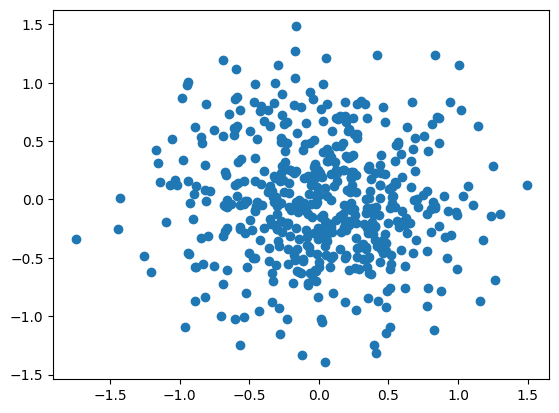

In [11]:
plt.scatter(np.real(alist), np.imag(alist))

In [12]:
np.std(np.abs(alist)**2)

0.5141224990748129

## Wigner Ensemble 

In [13]:
print(np.shape(uv_arr[:,0]))

(512,)


In [14]:
def calcPsiNoise(x): 
    psinoise = 1/np.sqrt(g.L) *np.sum(alist*uv_arr[:,0]*np.exp(1j*g.ki[0]*x)+np.conj(alist)*uv_arr[:,1]*np.exp(-1j*g.ki[0]*x))
    return psinoise 

In [15]:
psinoise = np.zeros_like(g.xi[0], dtype = np.complex_)

for i in range(len(psinoise)): 
    psinoise[i] = calcPsiNoise(g.xi[0][i])
    

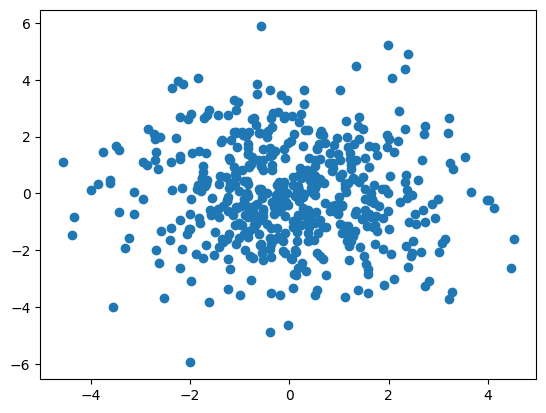

In [16]:
plt.scatter(np.real(psinoise), np.imag(psinoise))

In [17]:
psiwig = g.psi + psinoise 

C:\Users\TQC User\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


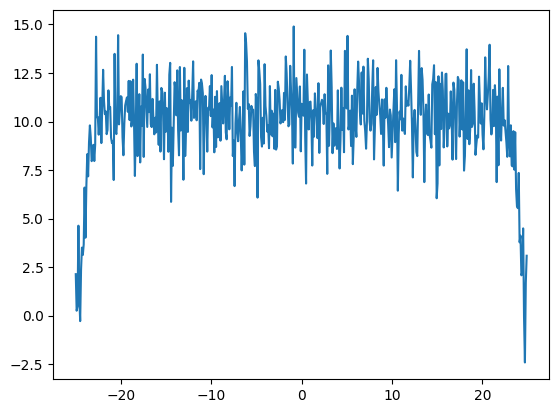

In [18]:
plt.figure() 
plt.plot(g.xi[0], psiwig)
plt.show()

In [19]:
print("Excess Atoms: ", np.sum(np.abs(psiwig)**2)*g.dx - g.Natoms) 

Excess Atoms:  283.27478236824936


## Creating an Ensemble 

We must create an ensemble of wavefunctions with such noise to be able to have an appropriate Wigner ensemble to accurately represent quantum noise.  

In [1]:
from bogoliubov import GPEBogoliubov as gpeb
import numpy as np
import matplotlib.pyplot as plt

In [20]:
num = 1000
npoints = 2**9 

ensemble_arr = np.zeros((num, npoints), dtype = np.complex_)
g0 = gpeb(npoints=npoints)
ensemble_arr[0] = g0.psiwig
for i in range(num-1): 
    g_b = gpeb(npoints=npoints, imp = True, impgpe = g0.gpe_obj)
    ensemble_arr[i+1] = g_b.psiwig

C:\Users\TQC User\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


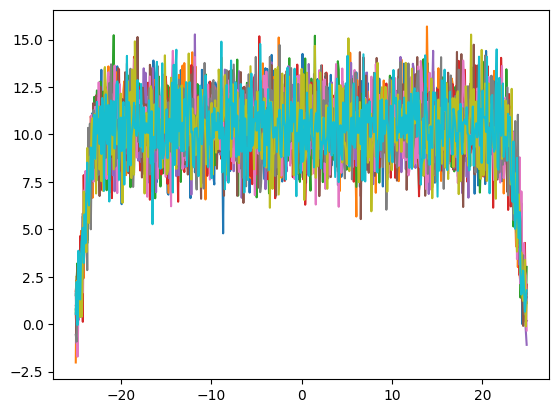

In [3]:
plt.figure() 
for ensemble in ensemble_arr: 
    plt.plot(g0.xi[0], ensemble)
plt.show() 

## Number Conserving Ensemble 

In [20]:
def renorm(): 
    b = np.real(np.dot(np.conj(g.psi),psinoise))*g.dx/g.Natoms 
    c = np.dot(np.conj(psinoise), psinoise)*g.dx/g.Natoms -1

    a1 = (-b + np.sqrt(b**2 - 4*c))/2
    a2 = (-b - np.sqrt(b**2 - 4*c))/2

    return max(a1, a2) 

In [21]:
a = renorm()

In [22]:
psiwig_renorm = a * g.psi + psinoise

In [23]:
np.sum(np.abs(psiwig_renorm)**2)*g.dx

5120.607126400718

## Evolving the Ensemble 

In [24]:
def Vpert(amp, width):         
    Vp = 0 
    Vp+= amp * np.exp(-width * g.xi[i]**2) 
    Vp[Vp < 10e-10] = 0 # Mathematica chop equivalent

    return Vp 



In [25]:
kinU = np.power(np.e, -(1.0j)*(g.k2)*g.dt)
        
snapshots = [psiwig] 
dynpsi = psiwig.copy() # set dynamic psi to evolve in time

for i in range(10000): 

    potU = np.power(np.e, -(1.0j) *((g.Vbox + g.Vpert)+g.g * np.abs(dynpsi)**2/2-1)*g.dt)
    psiFTold = np.fft.fftshift(np.fft.fftn(dynpsi))
    psiFTnew = np.array(psiFTold * kinU) 
    psiinterim = np.fft.ifftn(np.fft.ifftshift(psiFTnew))
    psinew = potU * psiinterim 
        
    #norm = np.sum(np.abs(psinew)**2) * g.dx
    #dynpsi = np.sqrt(g.Natoms/norm) * psinew
    if (i%250 == 0):
        snapshots.append(dynpsi)
    dynpsi = psinew 

snapshots = np.array(snapshots)

In [26]:
np.sum(np.abs(dynpsi)**2)*g.dx - g.Natoms

283.27478236919796

In [27]:
print(len(snapshots))

41


In [28]:

def animate_fig():
    fig=plt.figure()
    data, = plt.plot(g.xi[0], np.abs(snapshots[0]))




    def animate(i): 
        data.set_data(g.xi[0], np.abs(snapshots[i]))
        return [data] # Return what has been modified

    theAnim = animation.FuncAnimation(fig, animate, blit=True, repeat=True, frames = len(snapshots)) # Note the needed `theAnim` variable. Without it, the garbarge collector would destroy the animation before it is over
    plt.show()  
    return theAnim  


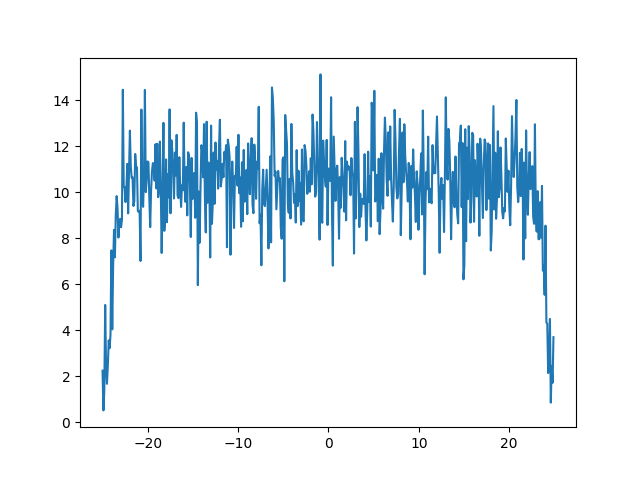

In [29]:
%matplotlib widget
animate_fig() 

## Averaging Out Over the Ensemble 

In [6]:
def kron(x1, x2): 
    if x1 == x2: 
        return 1
    else: 
        return 0 

In [7]:
def density(ensemble, dx): 
    dens = np.average(np.abs(ensemble)**2, axis = 0) - 1/(2*dx)
    return dens 

In [14]:
print(np.shape(np.average(np.abs(ensemble_arr)**2, axis = 0) - 1/(2*g0.gpe_obj.dx)))

(512,)


Let's create a function to determine the $g_2$ two-point correlation function. Let's store the values in a NxN matrix where N is the number of points. This will be flattened in 2 dimensions, but let's start with 1 dimension. 

In [40]:
np.matmul(np.array([[1,2]]).T, np.array([[1,2]]))

array([[1, 2],
       [2, 4]])

In [37]:
print(np.transpose(np.array([[1,2]])))

[[1]
 [2]]


In [8]:
# def twoPointCorr(image_ensemble):
    
#     # asssume 1D 
    
#     first_term = np.zeros((len(image_ensemble), len(image_ensemble[0]), len(image_ensemble[0]))) # NxN matrix that contains information about the average over the ensemble 
#     for i in range(len(image_ensemble)): 
#         image = image_ensemble[i] 
#         image_T = image.T # transpose of the image
#         mult = np.matmul(np.abs(image_T)**2, np.abs(image)**2)
#         first_term[i] = mult 
#     first_term_avg = np.average(first_term, axis = 0)
    
#     second_term = (1)
#     return 


def twoPointCorr_2(ind1, ind2, image_ensemble, x_arr, dx): 
    '''
    2-point correlation for a given two points in the image to determine the relatedness between them 
    '''
    psi_1 = image_ensemble[:,ind1]
    psi_2 = image_ensemble[:,ind2]
    x1 = x_arr[ind1]
    x2 = x_arr[ind2]

    first_term = np.average(np.abs(psi_1)**2*np.abs(psi_2)**2, axis = 0) 

    second_term = (1+kron(x1, x2))/(2*dx)(np.average(np.abs(psi_1)**2, axis = 0) + np.average(np.abs(psi_2)**2, axis = 0))

    third_term = (1 + kron(x1, x2))/(4*dx**2)

    denominator1 = np.average(np.abs(psi_1)**2, axis = 0) - 1/(2*dx)
    denominator2 = np.average(np.abs(psi_2)**2, axis = 0) - 1/(2*dx)

    numerator = first_term - second_term + third_term

    return numerator/(denominator1 * denominator2)
    

Test the above functions for the density and the two-point correlation function. For the density, check if the Wigner wavefunction is properly normalized still after the noise is added at the end.

## Testing the Density and Two-Point Correlation Calculations

In [22]:

dx = g0.gpe_obj.dx
dens = density(ensemble_arr, dx) 
print(np.shape(dens))
print(np.sum(dens)*g0.gpe_obj.dx)


(512,)
5136.573575855917
